In [321]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

mpl.rcParams.update({
    "figure.constrained_layout.use": True,
    "font.size": 20
})

plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

### Serial Dependence

- Time Dependence 와는 달리 시간적 의존이 아닌 이전 데이터에 따른 의존성

### Cycles(Serial Dependence 을 나타내는 일반적인 방법)

- 연속의존성을 나타내는 일반적인 방법은 Cycles(순환)
- 반드시 시간 단위로 반복되는 것이 아닌 순환적으로 스스로 이전 상황에 대하여 영향을 끼친다.

### Lagged Series and Lag plots

- 지연 피쳐 lag feature 만들기
- Reg plots : 선형에 가까울 수록 연속 의존성(Serial Dependence)이 높다
    

In [322]:
import yfinance as yf
import pandas as pd

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

In [323]:
# S&P 500 데이터 가져오기
snp_500 = yf.download('AAPL', start='2010-01-01', end='2020-12-31')

snp_500=pd.DataFrame(columns=[i[0] for i in snp_500.columns],
                     data=snp_500.values,
                     index=snp_500.index)

close_snp = snp_500[["Close"]].copy()
close_snp.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [324]:
close_snp["lag_1"] = close_snp["Close"].shift(1)
close_snp["lag_2"] = close_snp["lag_1"].shift(1)

In [325]:
close_snp.dropna(inplace=True)

In [326]:
sample = close_snp[:10]

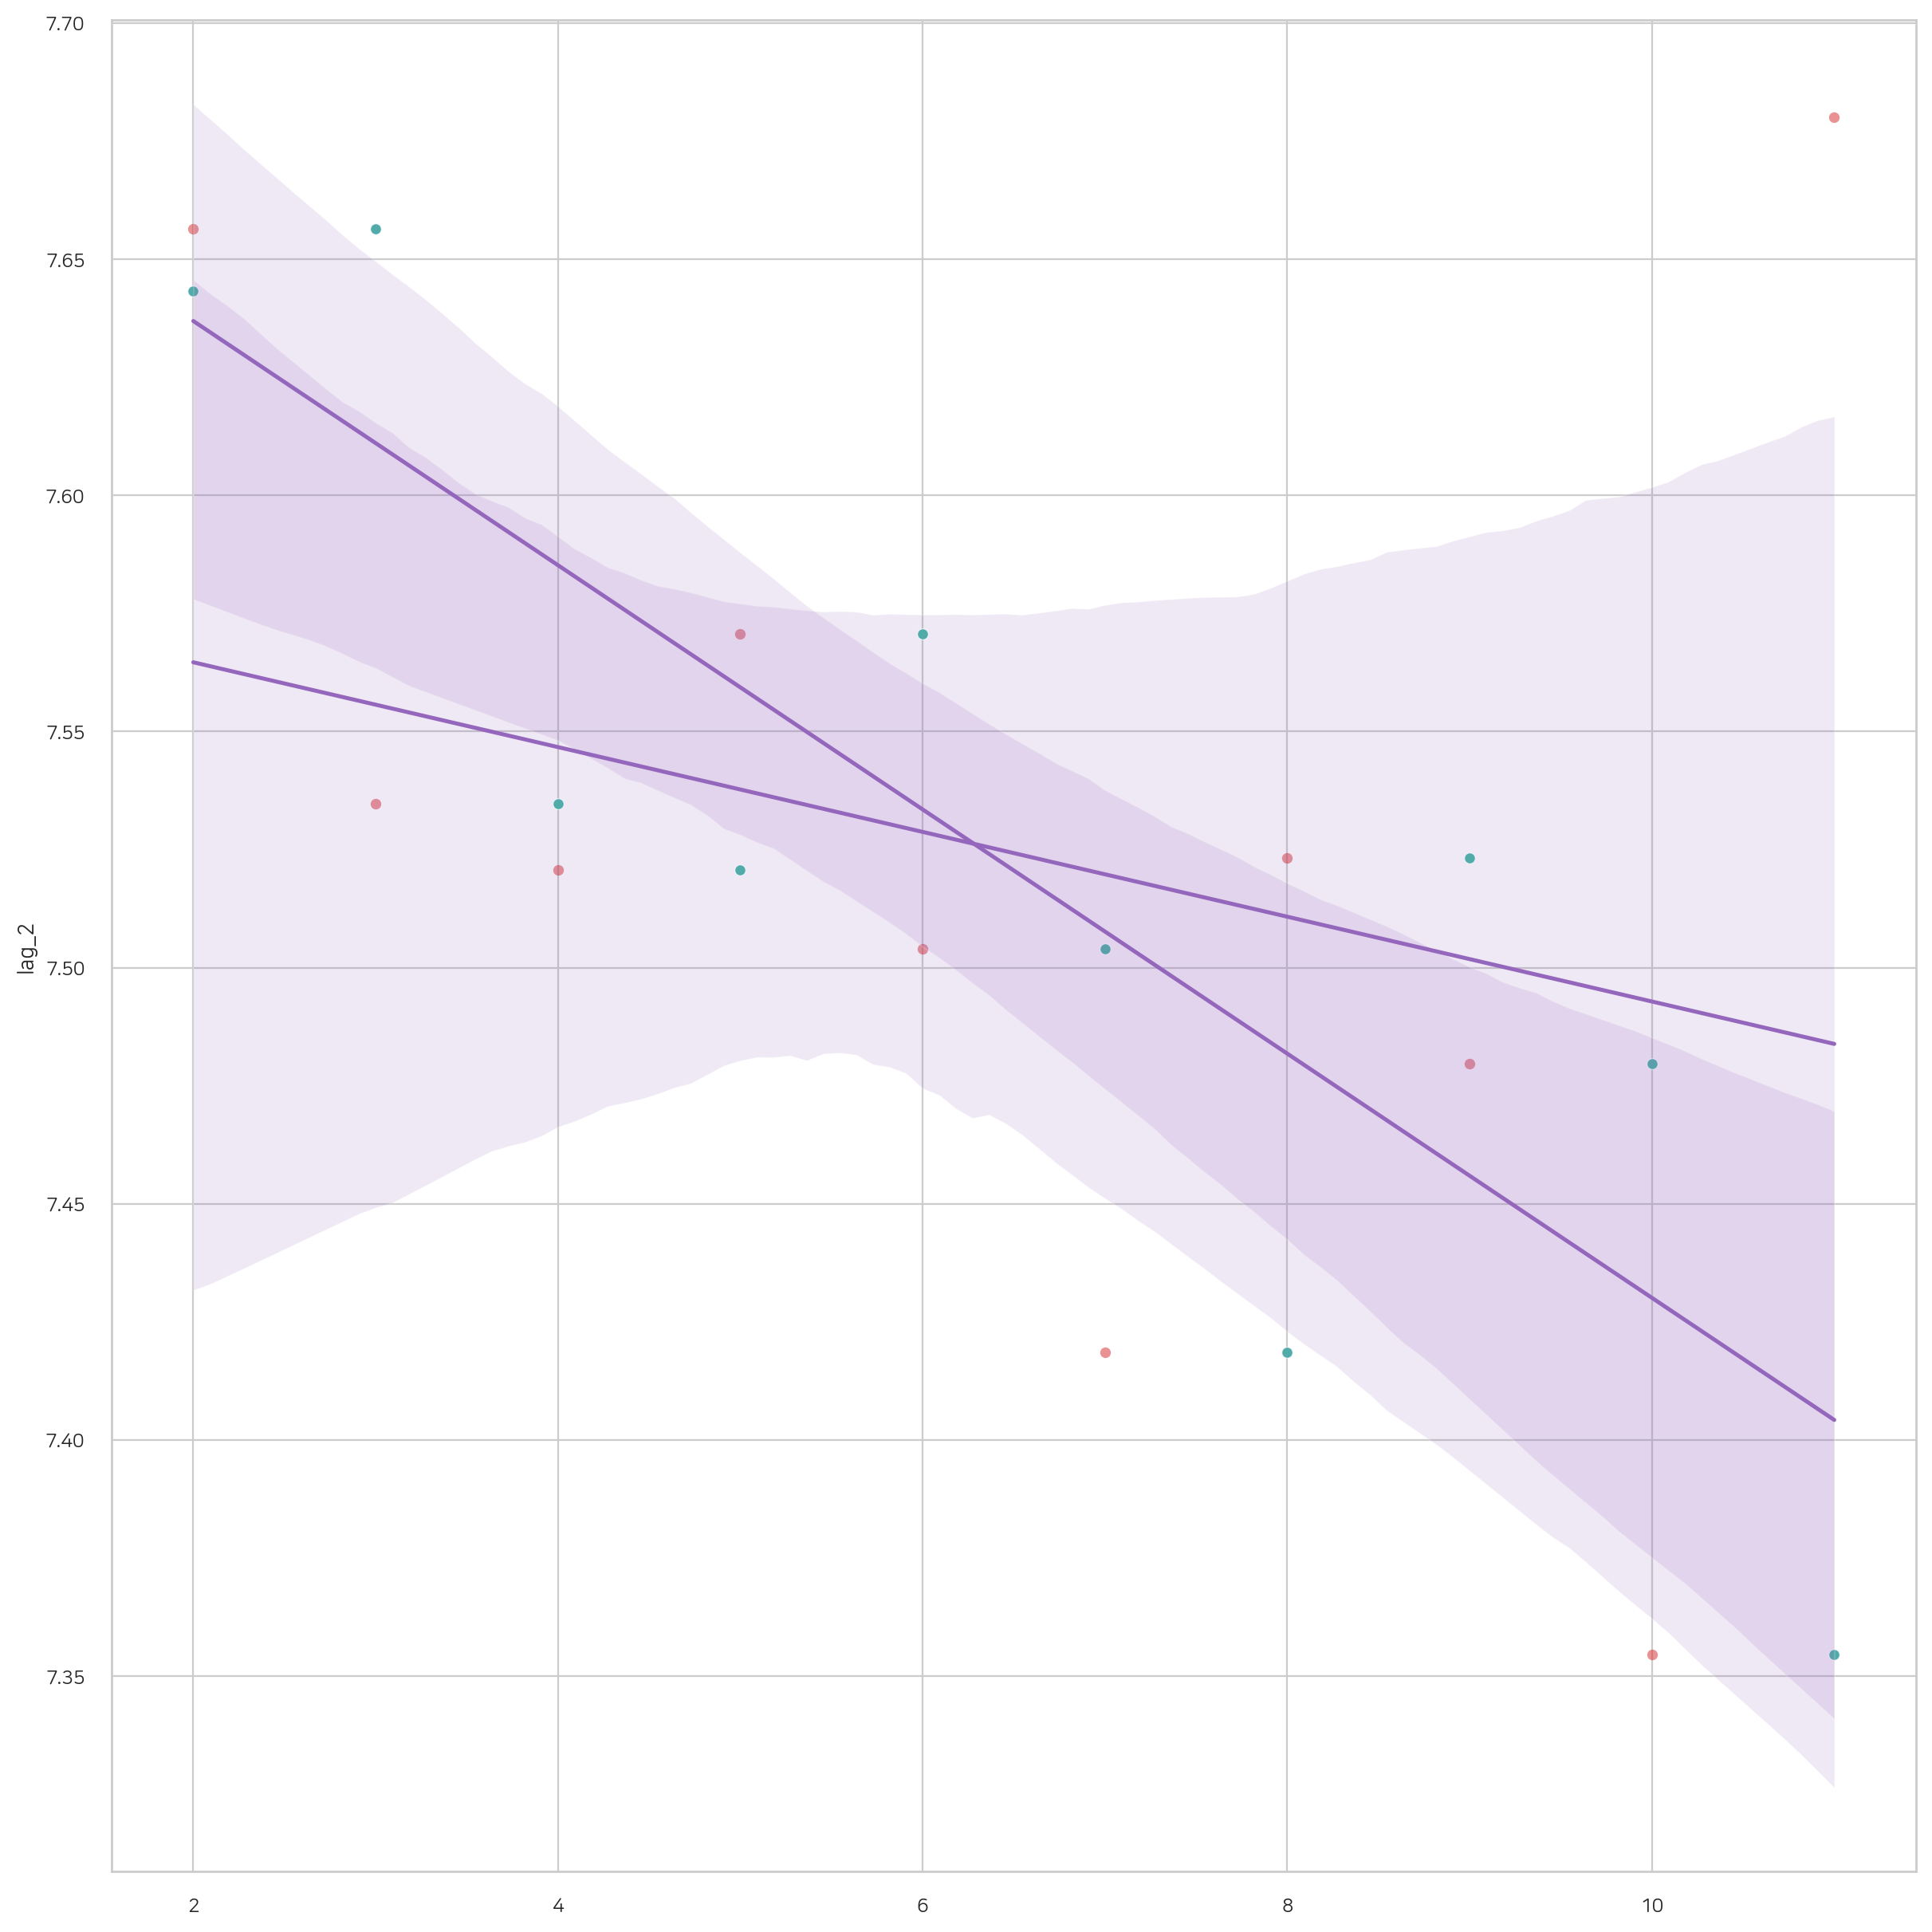

In [327]:
fig, ax = plt.subplots(figsize = (12,12))

# Regression plot
sns.regplot(data=sample,
            x=sample.index,
            y='lag_1',
            scatter_kws={"color": "tab:red", "alpha": 0.5},
            
            color="tab:purple",
            ax=ax
)

sns.scatterplot(data=sample,
                x=sample.index,
                y="lag_2",
                ax=ax)

sns.regplot(data=sample,
                x=sample.index,
                scatter_kws={"color": "tab:blue", "alpha": 0.3},
                color = "tab:purple",
                # lowess=True,
                y="lag_2",
                ax=ax);

- 자기 연관성 및 부분 자기 연관성 (Auto Corrleration and Partial Auto Correlration)


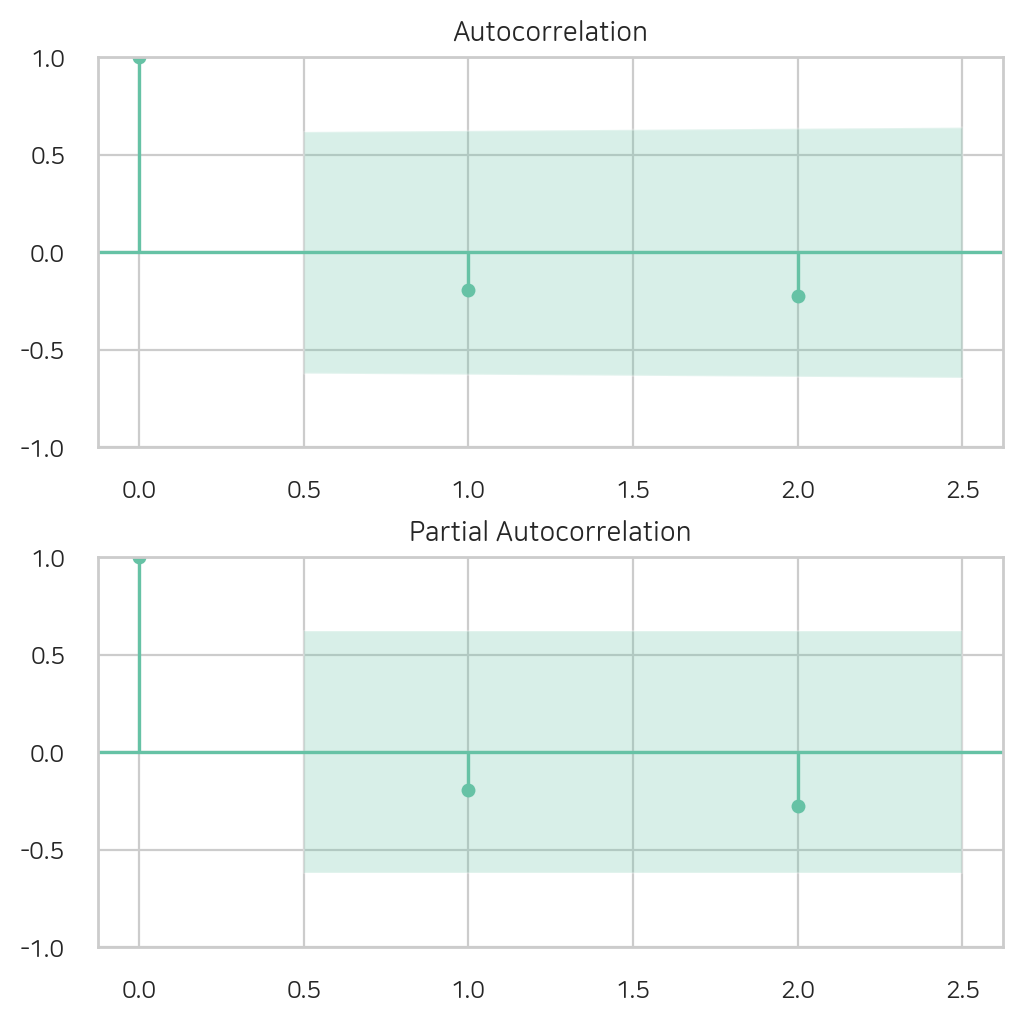

In [328]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(5,5))

plot_acf(sample["Close"], lags=2, ax=ax[0])
plot_pacf(sample["Close"], lags=2, ax=ax[1]);

![img](https://img.notionusercontent.com/s3/prod-files-secure%2Fe8f11927-b70c-4524-9227-a3efac08e7aa%2F591afd29-c384-4a59-a3c6-cdb7e74456f1%2FUntitled.png/size/w=2000?exp=1729822839&sig=22qNtzlETUcXl8P8YV-l6oLr8bm5gknCwpR8ztabSik)

1. 자기 연관성 : 현재 값과 이전 값 사이의 관련성 
    - 포인트 1 : 현재 피쳐와 이전 1번째 시간 지연 값의 연관성
    - 포인트 2 : 현재 피쳐와 이전 2번째 시간 지연 값의 연관성
    - …
    - 마지막 포인트 : 현재 피쳐와 마지막 시간 지연 값의 연관성
2. 부분 자기 연관성 : 
    - 이전 지연 데이터에 대한 새로운 연관성 : 그래프의 95 퍼센트 confidence interval(신뢰 구간) 넓이 안에 있다는 이야기는 새로운 연관성이 크게 보이지 않고, 이 넓이를 넘어서는 경우는 새로운 연관 성이 발견된 것
        - 새로운 연관성의 예시 (다른 데이터로 예시를 듦) - 이 경우 4번째 시간 지연 피쳐까지 의미가 있다고 볼 수 있다.

# 예시 1). 주식 데이터를 이용하여 자기 상관성 분석

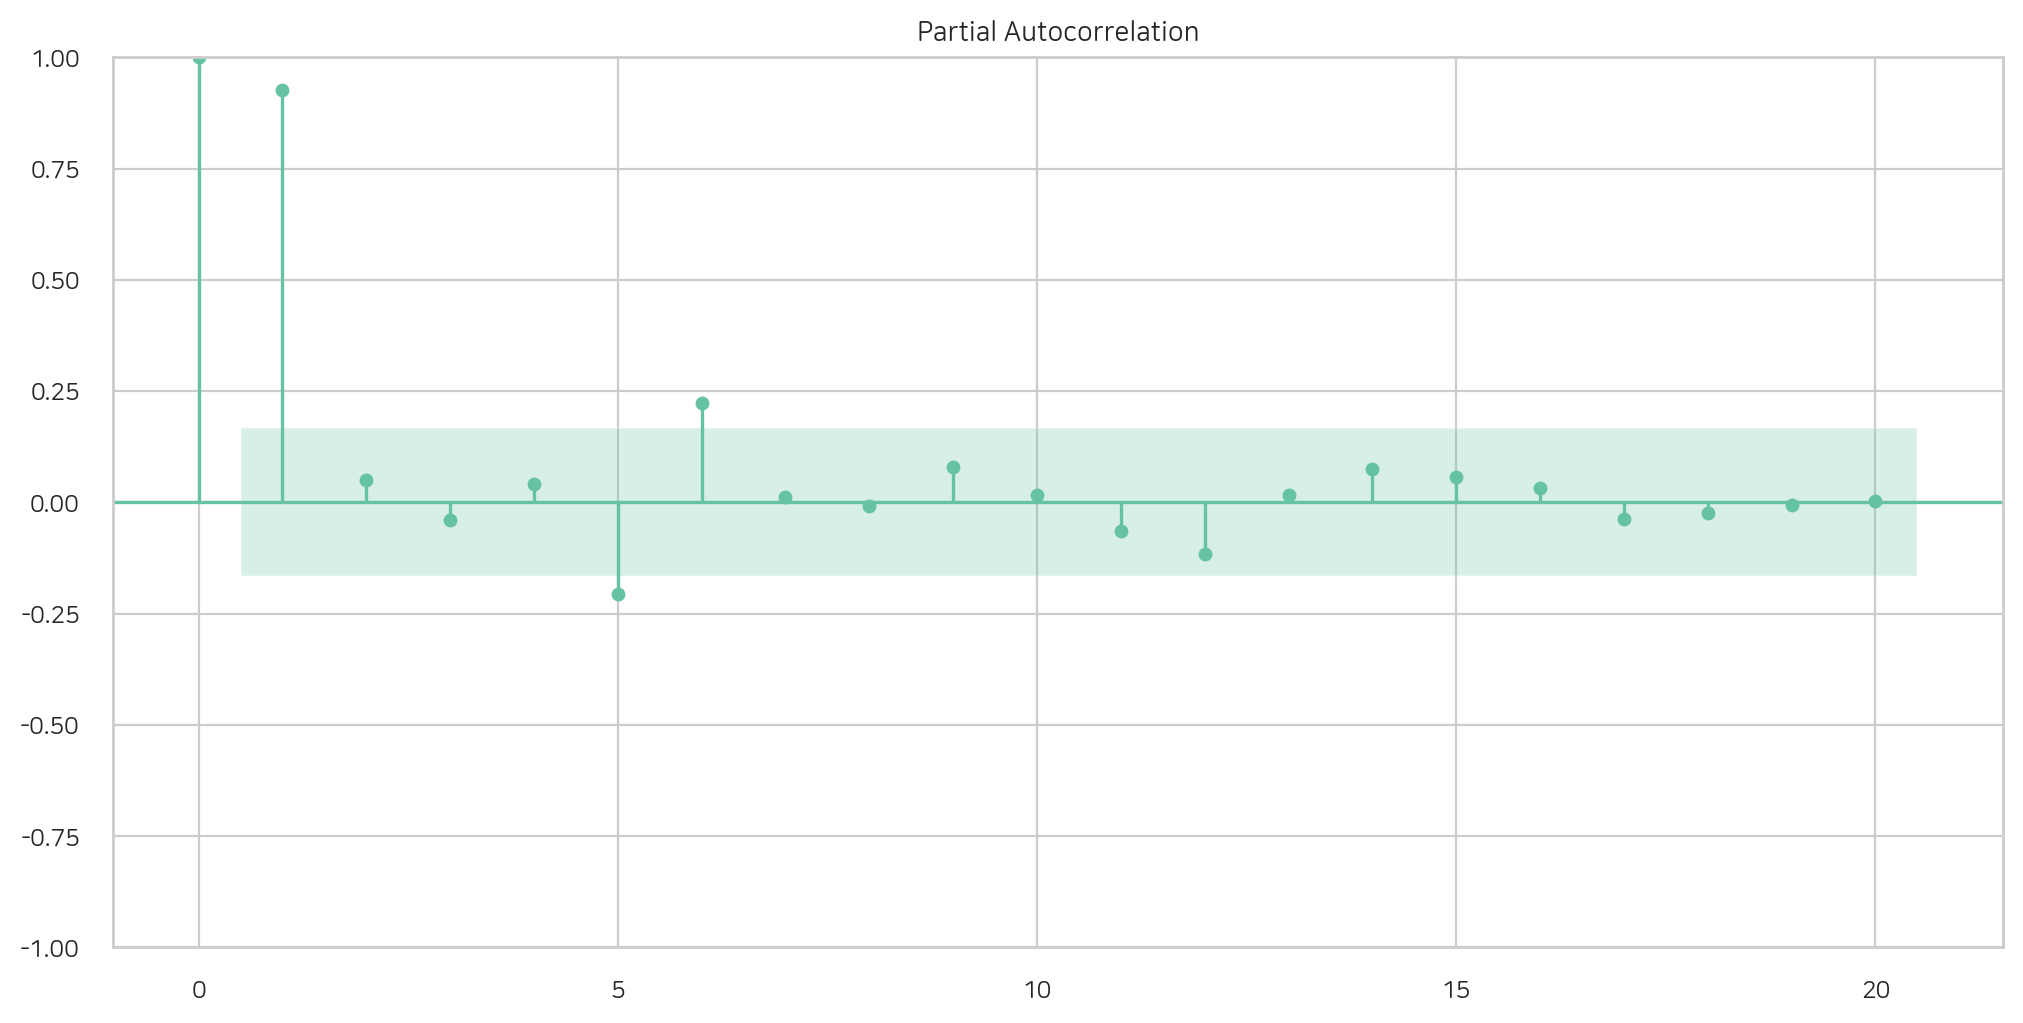

In [329]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

snp_20 = snp_500.iloc[0:-1:20] # 주말빼고 약 한달에 20일정도씩

fig, ax = plt.subplots(1,1, figsize=(10,5))

plot_pacf(snp_20['Close'], lags=20, ax=ax);

- snp500 데이터 불러오기 ( 약 한달 간격으로 자기 연관성 분석 )


- 1, 10, 19 lag 지연 feature를 기준으로 새로운 연관성이 나타났다. ( 그래프 상으로는 그렇지만, 주식의 불규칙한 상황이라 생각한다.)
    - 위 그래프르 시험해보기 위해 새로운 lag 피쳐 만들기

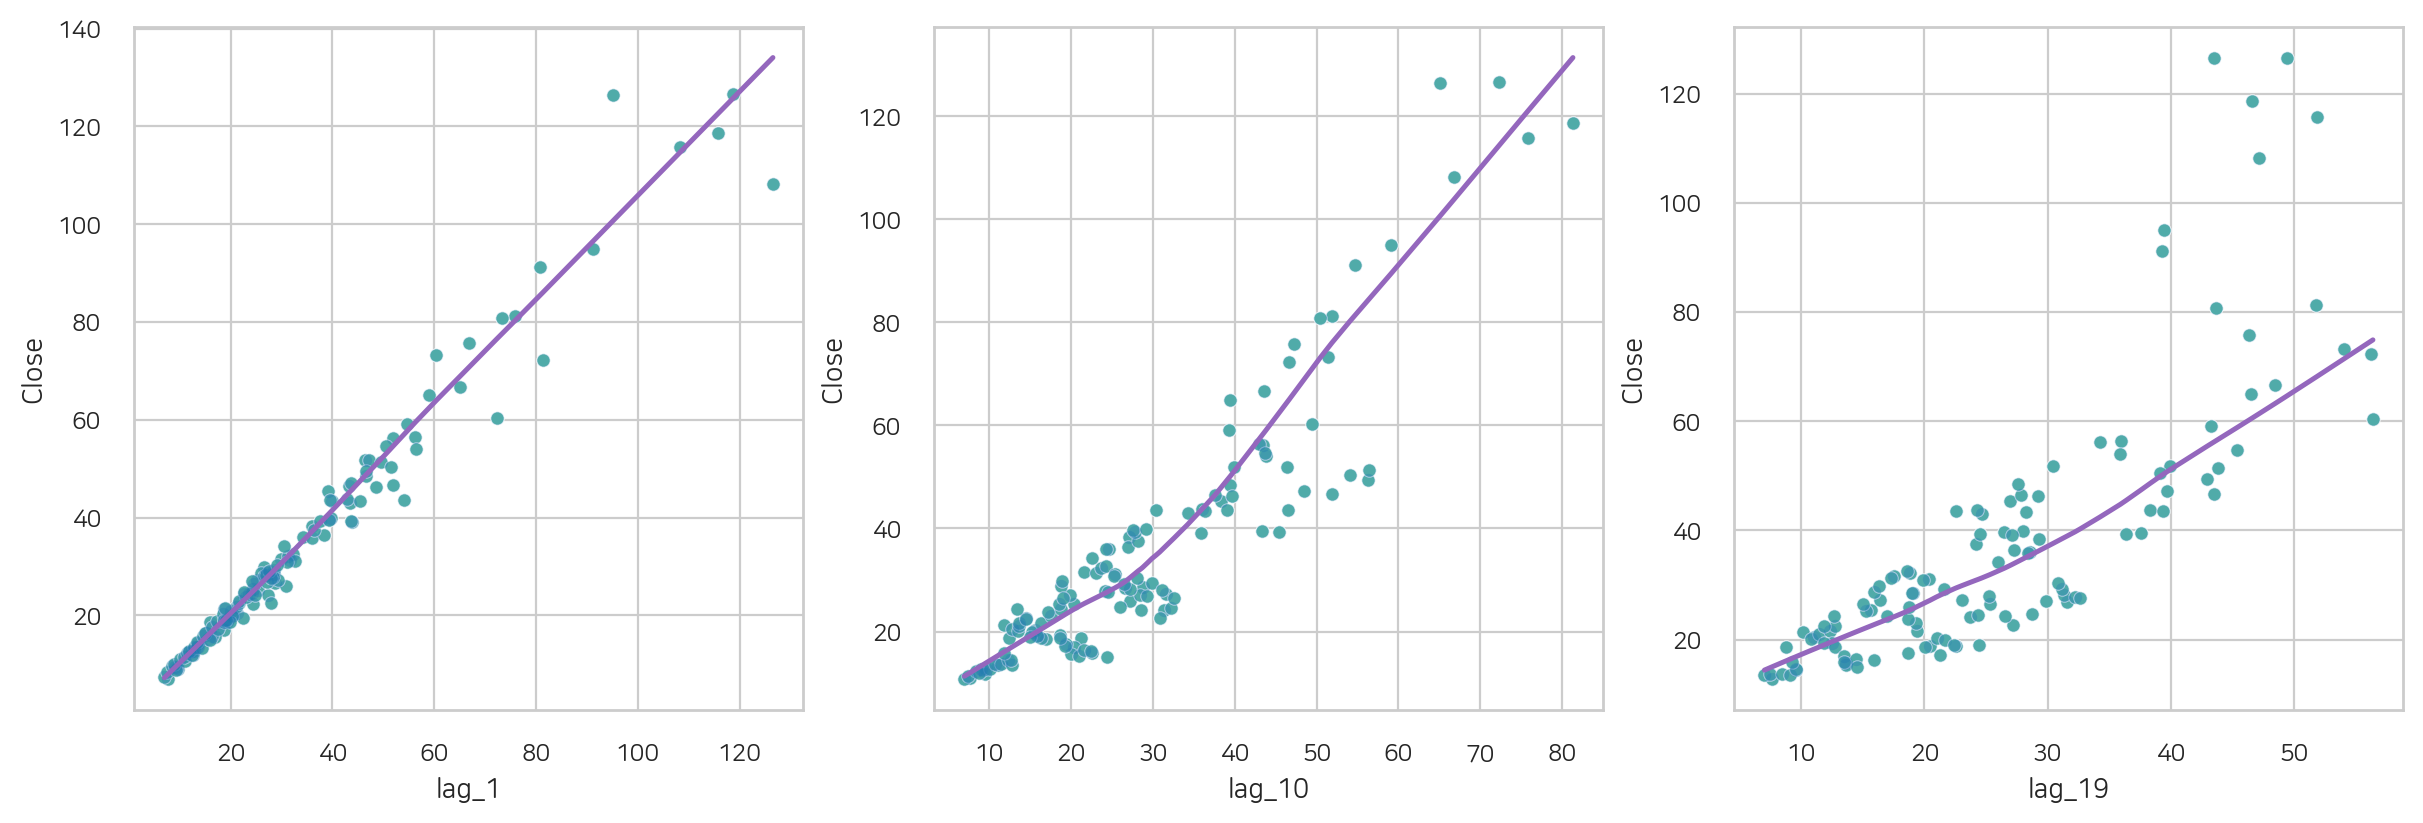

In [330]:
new_snp = snp_20[["Close"]].copy()
new_snp["lag_1"] = new_snp["Close"].shift(1)
new_snp["lag_10"] = new_snp["Close"].shift(10)
new_snp["lag_19"] = new_snp["Close"].shift(19)

fig, ax = plt.subplots(1,3, figsize=(12,4))
lags = [1,10,19]

for i in range(len(lags)):
    sns.scatterplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    ax=ax[i])
    
    sns.regplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    scatter_kws={"color": "tab:blue", "alpha": 0.3},
                    color = "tab:purple",
                    lowess=True,
                    ax=ax[i],)

- 그래프가 지연에 따라 변하는 모습을 보인다.


- 새로운 지연 피쳐를 이용해 Regression 학습 시켜보기

In [331]:
from sklearn.model_selection import train_test_split

new_snp.dropna(inplace=True)

train_size = 110

X_train = new_snp.drop(columns=["Close"]).iloc[:train_size]
y_train = new_snp["Close"].iloc[:train_size]
X_test = new_snp.drop(columns=["Close"]).iloc[train_size:]
y_test = new_snp["Close"].iloc[train_size:]

In [332]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)


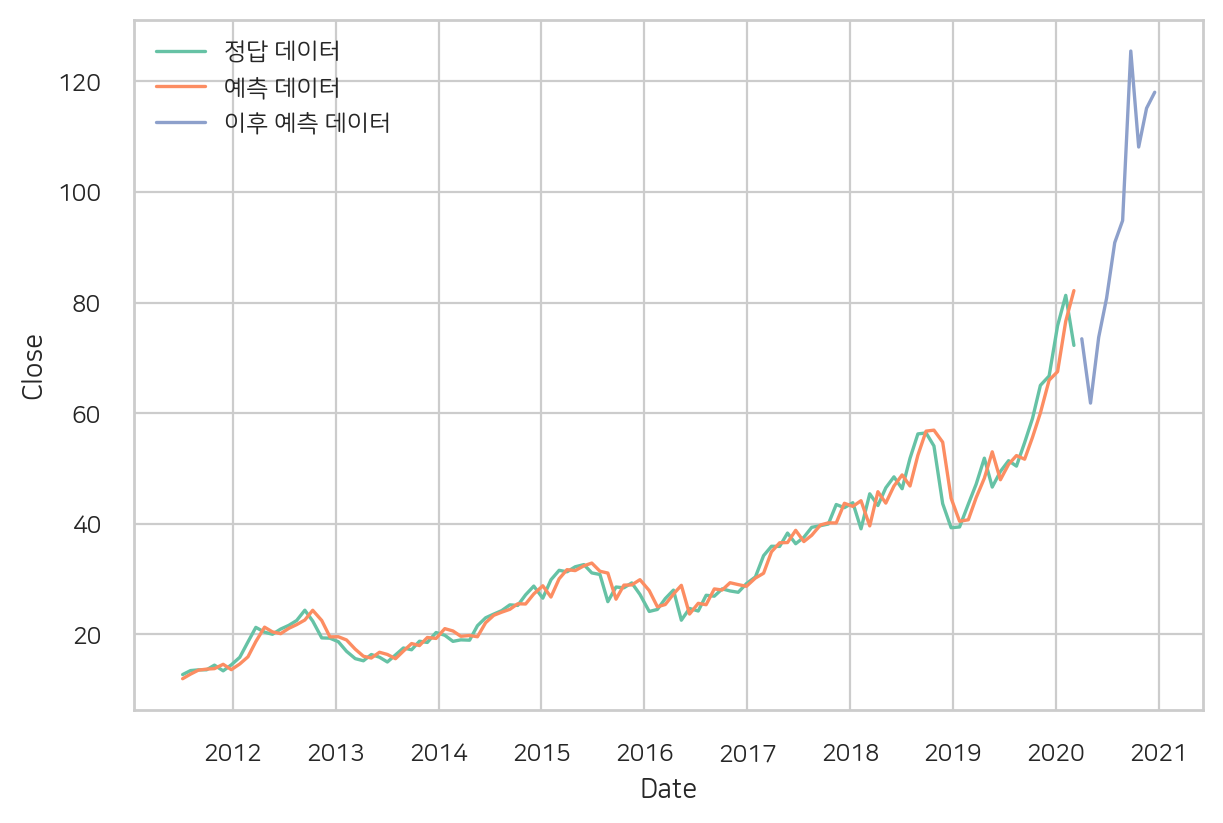

In [333]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.lineplot(data=y_train,
             label="정답 데이터",
             ax=ax)

sns.lineplot(data=y_pred,
             label="예측 데이터",
             ax=ax)

sns.lineplot(data=y_fore,
             label="이후 예측 데이터",
             ax=ax);

- 예상대로 두 그래프의 차이는 미묘 했다. (지연 10 과 19 에 대한 새로운 연관성은 노이즈에 불과했다)

- 마지막으로 이동평균 피쳐를 추가하여 fit 시키기

In [334]:
# 1. lag 피쳐의 모델 (lag_1, lag_10, lag_19)
X_train_f, X_test_f, y_train_f, y_test_f = X_train,X_test, y_train, y_test

model_f = LinearRegression()
model_f.fit(X_train, y_train)
y_pred_2 = pd.Series(model_f.predict(X_train_f), index=y_train_f.index)
y_fore_2 = pd.Series(model_f.predict(X_test_f), index=y_test_f.index)

# 2. 이동 평균선 + 피쳐 (lag_1, moving_mean)
new_snp["moving_mean"] = new_snp["Close"].rolling(window=5,center=True).mean()
new_snp.dropna(axis=0, inplace=True)

X = new_snp.drop(columns=["Close"])
y = new_snp["Close"]

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X[["lag_1","moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm, y_train_mm)
y_pred_3 = pd.Series(model_mm.predict(X_train_mm), index=y_train_mm.index)
y_fore_3 = pd.Series(model_mm.predict(X_test_mm), index=y_test_mm.index)

# 3. 이동 평균선만으로 (moving_mean)
X_train_mm_2, X_test_mm_2, y_train_mm_2, y_test_mm_2 = train_test_split(X[["moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm_2, y_train_mm_2)
y_pred_4 = pd.Series(model_mm.predict(X_train_mm_2), index=y_train_mm_2.index)
y_fore_4 = pd.Series(model_mm.predict(X_test_mm_2), index=y_test_mm_2.index)

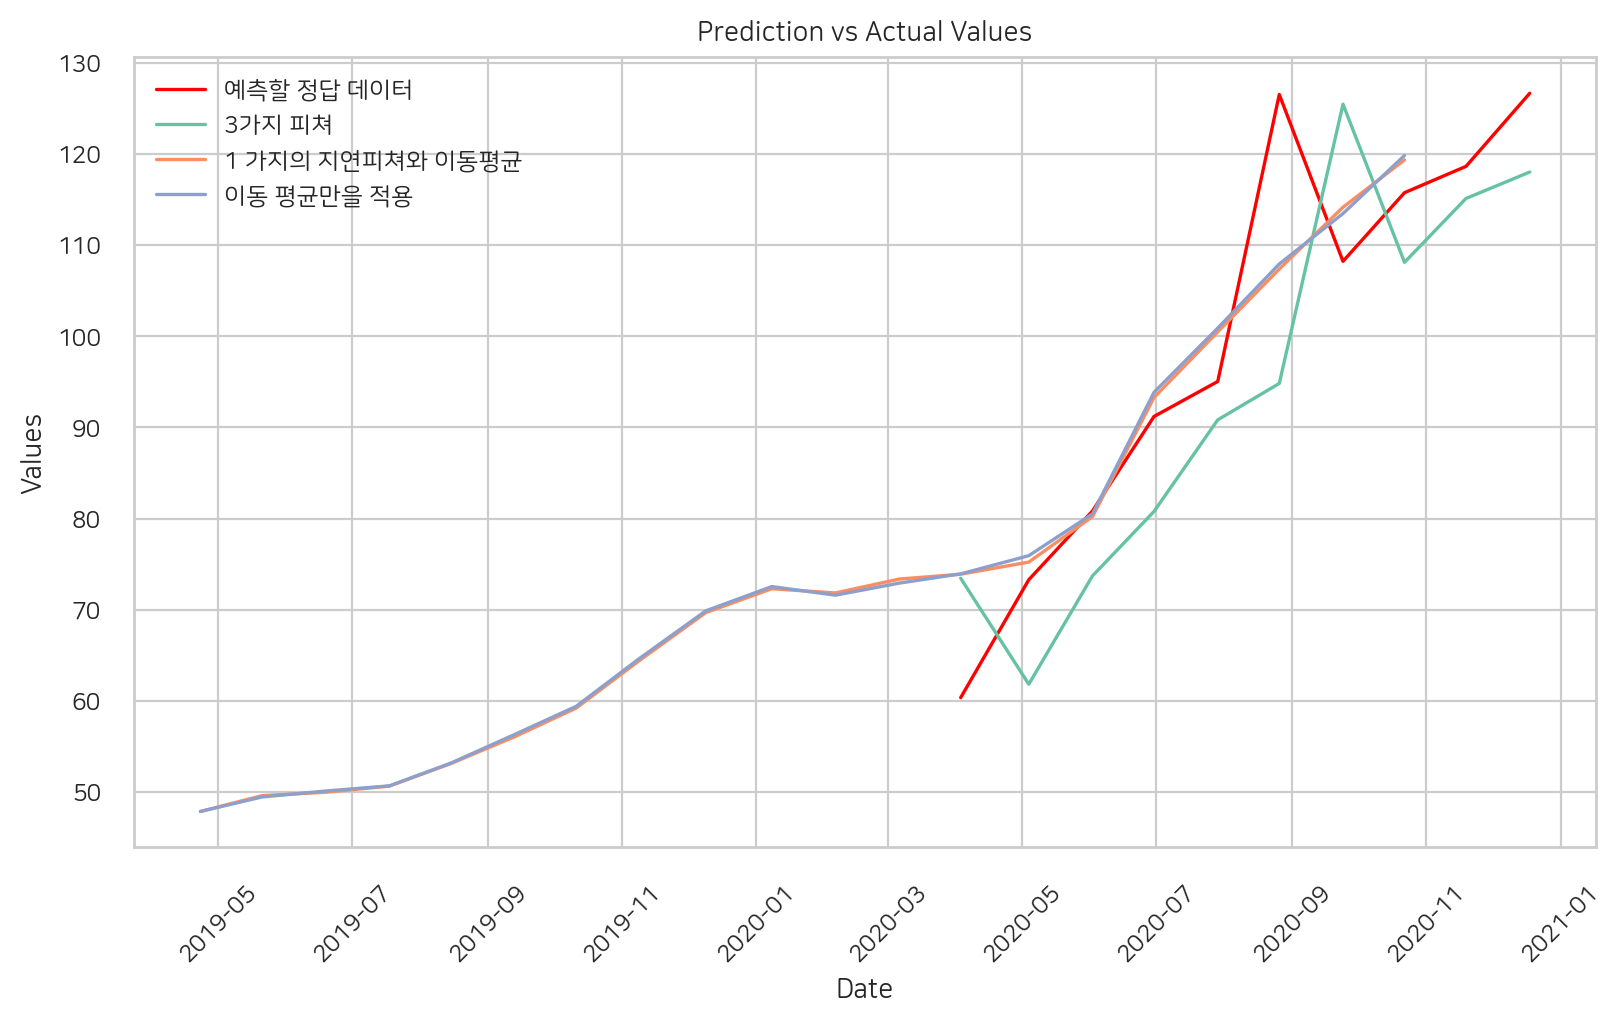

In [338]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

sns.lineplot(x=y_test.index,
             y=y_test,
             color="red",
             label="예측할 정답 데이터",
             ax=ax)

sns.lineplot(x=y_fore_2.index,
             y=y_fore_2,
             label="3가지 피쳐",
             ax=ax)

sns.lineplot(x=y_fore_3.index,
             y=y_fore_3,
             label="1 가지의 지연피쳐와 이동평균",
             ax=ax)

sns.lineplot(x=y_fore_4.index,
             y=y_fore_4,
             label="이동 평균만을 적용",
             ax=ax)

ax.set(xlabel='Date', ylabel='Values', title = "Prediction vs Actual Values")
plt.xticks(rotation=45);

- 평균 제곱 오차 구하기

In [339]:
from sklearn.metrics import mean_squared_error

print("""\
3종의 시간지연 MSE : {:0.2f}
이동평균  MSE : {:0.2f}
이동평균과 1종의 시간 지연 MSE : {:0.2f}\
""".format(
mean_squared_error(y_test_f,y_fore_2),
mean_squared_error(y_test_mm_2,y_fore_4),
mean_squared_error(y_test_mm,y_fore_3),
))

3종의 시간지연 MSE : 192.76
이동평균  MSE : 38.66
이동평균과 1종의 시간 지연 MSE : 39.17


- 3종의 시간지연 MSE : 51960.70
- 이동평균  MSE : 21661.19
- 이동평균과 1종의 시간 지연 MSE : 21629.98

- 비교 결과:
    - 1등 : 이동 평균 + 1 Lag
    - 2등 : 이동 평균
    - 3등 : 3종류의 시간지연